In [2]:
import matplotlib as mp
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

from data import *
from custom_dataset import *
from tarea1_models import *

import matplotlib.pyplot as plt


In [3]:
def crear_diccionario(IDs, labels):
    y = {}

    # crear diccionario de labels
    for idx, img in enumerate(IDs):
        y[img] = labels[idx]
    
    return y

In [4]:
tf.keras.backend.clear_session()

# se debe crear el dataset
data_dir = 'Sketch_EITZ'

real_labels = {}
mapping = 'Sketch_EITZ/mapping.txt'
with open(mapping) as file:
    for ln in file:
        arg, label = ln.strip().split('\t')
        real_labels[label] = arg

X_train = []
Z = []
img_size = 255

train_images, train_labels = read_data_from_file(data_dir, 'train')
test_images, test_labels = read_data_from_file(data_dir, 'test')


train_images, val_images, y_train, y_val = train_test_split(
        train_images, train_labels, test_size=0.2, random_state=42)

a = 'samples\ntrain: {} val: {} test: {}\t'
print(a.format(len(train_images), len(val_images), len(test_images)))

y_train = crear_diccionario(train_images, y_train)
y_val = crear_diccionario(val_images, y_val)

# training_generator = DataGenerator(train_images, y_train)
# val_generator = DataGenerator(val_images, y_val)

samples
train: 12800 val: 3200 test: 4000	


In [9]:
X_train = []
for idx, img in tqdm(enumerate(train_images)):
    print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))
    X_train.append(np.array(img) / 255)
    if idx == 10: break

    
print(X_train.shape)

10it [00:00, 625.13it/s]

Sketch_EITZ/png_w256/car_sedan/3620.png
Sketch_EITZ/png_w256/nose/11169.png
Sketch_EITZ/png_w256/flashlight/6680.png
Sketch_EITZ/png_w256/fire_hydrant/6487.png
Sketch_EITZ/png_w256/scorpion/14431.png
Sketch_EITZ/png_w256/leaf/9602.png
Sketch_EITZ/png_w256/mouth/10897.png
Sketch_EITZ/png_w256/grenade/7573.png
Sketch_EITZ/png_w256/boomerang/2158.png
Sketch_EITZ/png_w256/cat/3845.png
Sketch_EITZ/png_w256/person_walking/12182.png
[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [25

In [6]:
inputs = keras.Input(shape=(256, 256, 3))

conv1 = layers.Conv2D(64, (3,3), padding='same', strides=2, kernel_initializer='he_normal')(inputs)
x = layers.BatchNormalization()(conv1)

# bloque 1 vgg
for i in range(4):
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)

# bloque 2 vgg
for i in range(4):
    x = layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)

# bloque 3 vgg
for i in range(4):
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)

# bloque 4 vgg
for i in range(4):
    x = layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)

# bloque 5 vgg
for i in range(4):
    x = layers.Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

# x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)

x = layers.Flatten()(x)

x = layers.Dense(250, activation='relu')(x)

model = keras.Model(inputs, x, name='BasicVGG')


In [7]:
print(model.summary())

Model: "BasicVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      369

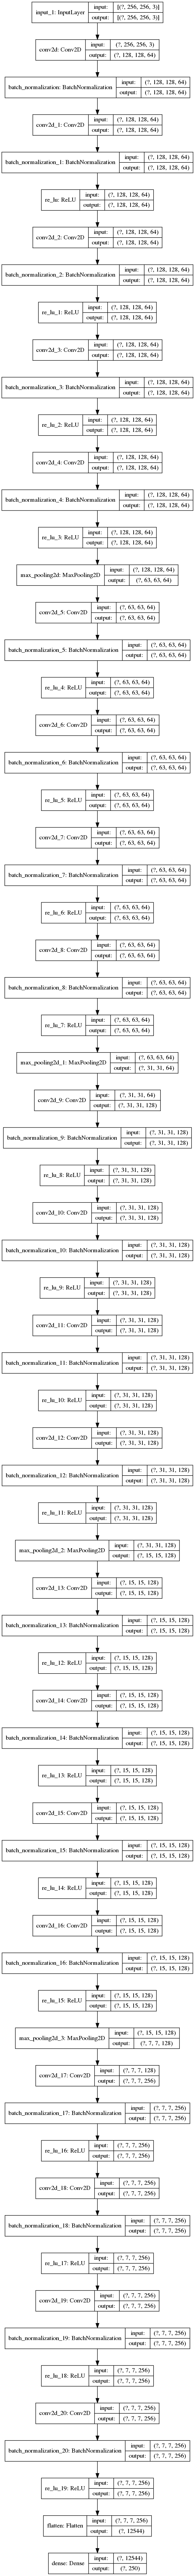

In [8]:
keras.utils.plot_model(model, './BasicVGG.png', show_shapes=True, expand_nested=True)

In [9]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
history = model.fit(training_generator,
                    validation_data=val_generator,
                    use_multiprocessing=True,
                    workers=4)

 48/400 [==>...........................] - ETA: 1:03:19 - loss: 5.5609 - accuracy: 0.0059

Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/martin/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/martin/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/martin/anaconda3/envs/tf/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/martin/anaconda3/envs/tf/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Process Keras_worker_ForkPoolWorker-3:
  File "/home/martin/anaconda3/envs/tf/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
  File "/home/martin/anaconda3/envs/tf/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/ho

KeyboardInterrupt: 